<a href="https://colab.research.google.com/github/karinaleskiewicz06/Skin-Cancer-Classification-HAM10000/blob/main/mendeley_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://data.mendeley.com/datasets/ydrm75xywg/1

1. Jaki format danych?
Zbiór jest hybrydowy i zawiera:

Wideo: Pliki w formacie .avi.

Adnotacje/Etykiety: Pliki tekstowe .csv (standardowy format tabelaryczny).

Pomiary wydajności: Arkusze .xlsx (Excel) zawierające czasy inferencji (timing).

Struktura ramek: Prawdopodobnie format Pascal VOC (xmin, ymin, xmax, ymax) zapisany wewnątrz CSV.

2. Ile danych? (Objętość)
Całe archiwum ma około 1.4 GB. Jest to zbiór średniej wielkości, zoptymalizowany pod kątem benchmarkingu (porównywania) różnych architektur modeli na tych samych sekwencjach wideo.

3. Ile parametrów? (Atrybuty w CSV)
W plikach train_labels.csv i test_labels.csv znajduje się zazwyczaj 8 parametrów (kolumn):

filename: nazwa pliku/klatki.

width: szerokość obrazu.

height: wysokość obrazu.

class: nazwa wykrytego obiektu (np. person, car).

xmin, ymin, xmax, ymax: współrzędne ramki otaczającej.

4. Z jakiego źródła dane?
Dane pochodzą z repozytorium Mendeley Data. Autorem zbioru jest zespół naukowy badający systemy monitoringu wizyjnego (Video Surveillance). Są to realne nagrania z kamer przemysłowych poddane obróbce przez różne modele detekcyjne.

5. Ile zdjęć w serii, total i ile serii?
Zbiór opiera się na sekwencjach wideo, które zostały pocięte na klatki (frames):

Liczba serii (Wideo): W folderach takich jak video_test widoczne są kody serii, np. 14-001, 14-003. Jest ich zazwyczaj kilkanaście różnych scenariuszy.

Zdjęć w serii: Każda seria to krótkie wideo (kilka-kilkanaście sekund), co przy 25-30 fps daje od 100 do 500 klatek na serię.

Total: Zbiór zawiera łącznie kilka tysięcy adnotowanych klatek (zazwyczaj ok. 2000-5000 w zależności od wersji podzbioru).

6. Czy adnotowany?
Tak, w pełni.

Masz pliki train_labels.csv oraz test_labels.csv, które stanowią tzw. Ground Truth (prawdę obiektywną).

Dodatkowo folder video_test zawiera pliki, które są wynikiem działania konkretnych algorytmów (np. #faster_rcnn), co pozwala na porównanie adnotacji ręcznych z automatycznymi.

In [ ]:
import os
import glob
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

download_link = "https://data.mendeley.com/public-files/datasets/ydrm75xywg/files/e05a41c5-6219-4d07-ba9d-d203ec718991/file_downloaded"


print("downloading file...")
!wget -O outer_archive.zip "$download_link"

print("unzipping...")
!unzip -q outer_archive.zip


!rm outer_archive.zip

# finding all the zip folders
inner_zips = glob.glob('**/*.zip', recursive=True)

if inner_zips:
    inner_zip_path = inner_zips[0]
    print(f"found inner file: {inner_zip_path}")
    print("more unzipping...")
    !unzip -q "{inner_zip_path}"

    !rm "{inner_zip_path}"
    print("all layers done")
else:
    print("zip not found")


downloading file...
--2026-02-18 22:47:11--  https://data.mendeley.com/public-files/datasets/ydrm75xywg/files/e05a41c5-6219-4d07-ba9d-d203ec718991/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/a002ad8a-5e7b-47a7-98e6-1cbe9d62f925 [following]
--2026-02-18 22:47:12--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/a002ad8a-5e7b-47a7-98e6-1cbe9d62f925
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.18.82, 52.218.45.34, 3.5.74.92, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|5

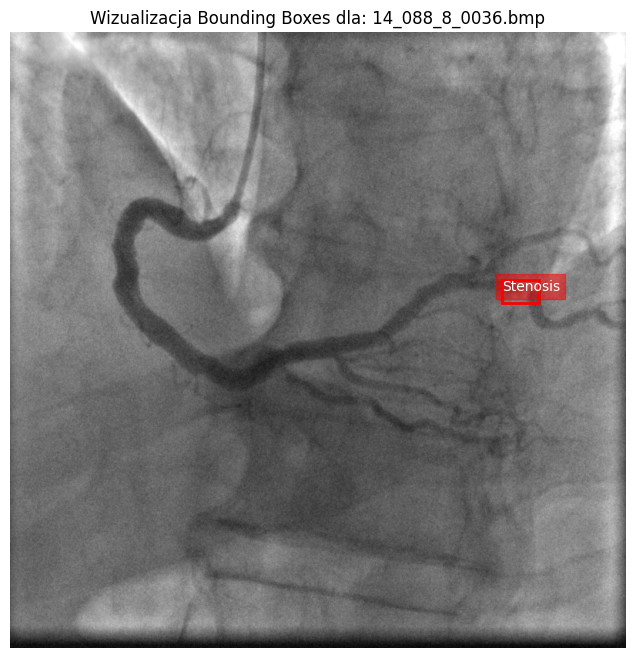

In [ ]:
import cv2
import matplotlib.patches as patches

def plot_random_bbox(df, images_path):
    # Wybieramy losowy plik, który ma przypisane ramki
    sample_file = random.choice(df['filename'].unique())
    sample_df = df[df['filename'] == sample_file]

    # Wczytanie obrazu
    img_path = os.path.join(images_path, sample_file)
    if not os.path.exists(img_path):
        print(f"Plik {img_path} nie został znaleziony. Sprawdź ścieżkę do folderu z obrazami.")
        return

    image = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Rysowanie ramek
    for _, row in sample_df.iterrows():
        # Pobranie współrzędnych
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin

        # Tworzenie prostokąta
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Dodanie etykiety klasy
        plt.text(xmin, ymin, row['class'], color='white', verticalalignment='top',
                 bbox={'color': 'red', 'alpha': 0.5})

    plt.title(f"Wizualizacja Bounding Boxes dla: {sample_file}")
    plt.axis('off')
    plt.show()

# Wywołanie (upewnij się, że 'dataset' to folder z obrazami wyciągniętymi z zipa)
plot_random_bbox(train_labels, 'dataset')

Średnia powierzchnia ramki: 1939.484719071133


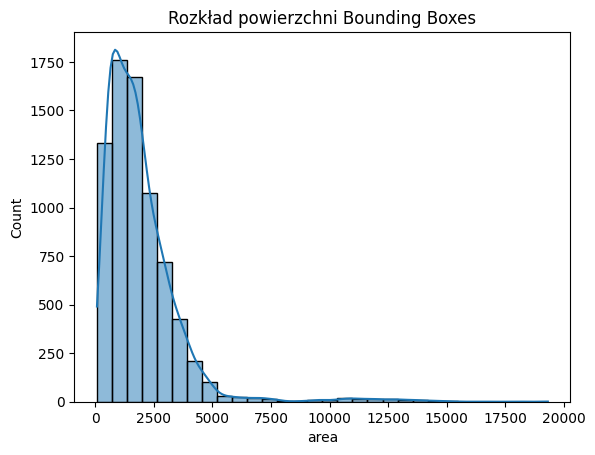

In [ ]:
# Szybka statystyka wielkości ramek
train_labels['bbox_width'] = train_labels['xmax'] - train_labels['xmin']
train_labels['bbox_height'] = train_labels['ymax'] - train_labels['ymin']
train_labels['area'] = train_labels['bbox_width'] * train_labels['bbox_height']

print("Średnia powierzchnia ramki:", train_labels['area'].mean())
sns.histplot(train_labels['area'], bins=30, kde=True)
plt.title("Rozkład powierzchni Bounding Boxes")
plt.show()

Dominacja małych obiektów: Średnia powierzchnia ramki wynosi 1939.48 pikseli. Dla obrazów o standardowej rozdzielczości (np. 720p lub 1080p), ramka o powierzchni ok. 1900 px (np. kwadrat o bokach 44x44 px) jest uznawana za mały obiekt.

Rozkład asymetryczny prawostronny: Większość ramek skupia się w przedziale 0–3000 px. Oznacza to, że Twój model detekcji musi być szczególnie dobrze zoptymalizowany pod kątem wykrywania niewielkich detali, co jest typowe dla nagrań z kamer monitoringu (postacie/pojazdy w oddali).

Wartości odstające (Outliers): Wykres pokazuje "długi ogon" sięgający aż do 20 000 px. Są to pojedyncze przypadki dużych obiektów, prawdopodobnie znajdujących się bardzo blisko obiektywu kamery.

--- Train Labels Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7493 non-null   object
 1   width     7493 non-null   int64 
 2   height    7493 non-null   int64 
 3   class     7493 non-null   object
 4   xmin      7493 non-null   int64 
 5   ymin      7493 non-null   int64 
 6   xmax      7493 non-null   int64 
 7   ymax      7493 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 468.4+ KB
None

--- Przykładowe dane (Train) ---


,filename,width,height,class,xmin,ymin,xmax,ymax
0,14_024_2_0042.bmp,800,800,Stenosis,235,156,282,192
1,14_031_4_0031.bmp,800,800,Stenosis,419,319,446,349
2,14_046_5_0066.bmp,1000,1000,Stenosis,679,307,699,336
3,14_010_6_0035.bmp,512,512,Stenosis,94,244,126,286
4,14_014_1_0015.bmp,512,512,Stenosis,163,118,203,151


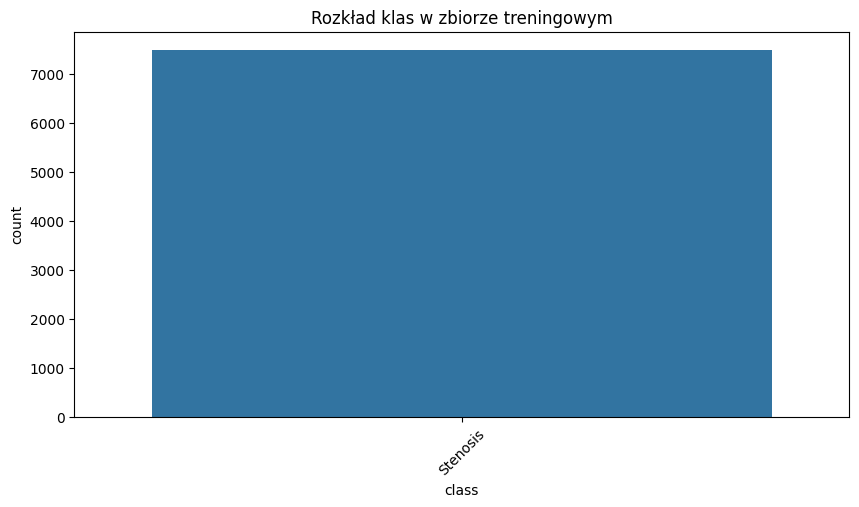

In [ ]:
# Wczytanie plików
train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

# Poprawne wczytanie timing_test.xlsx, traktując wiersz 1 (indeks 1) jako nagłówki
timing_test = pd.read_excel('timing_test.xlsx', header=1)
# Usuwamy niepotrzebne kolumny 'Unnamed: 0' i 'Unnamed: 1' jeśli istnieją
timing_test = timing_test.drop(columns=['Unnamed: 0', 'Unnamed: 1'], errors='ignore')

# Konwersja kolumn z czasami inferencji na typ numeryczny
# Identyfikujemy kolumny, które prawdopodobnie zawierają czasy inferencji
inference_time_cols = [col for col in timing_test.columns if 'inference time' in str(col).lower() or 'coco' in str(col).lower() or 'fpn' in str(col).lower()]
for col in inference_time_cols:
    timing_test[col] = pd.to_numeric(timing_test[col], errors='coerce')

print("--- Train Labels Info ---")
print(train_labels.info())
print("\n--- Przykładowe dane (Train) ---")
display(train_labels.head())

# Sprawdzenie balansu klas
plt.figure(figsize=(10, 5))
sns.countplot(data=train_labels, x='class') # Zakładając, że kolumna nazywa się 'class'
plt.title('Rozkład klas w zbiorze treningowym')
plt.xticks(rotation=45)
plt.show()

Current columns in timing_test: ['File', 'Images', 'Image size', 'ssd_mobilenet_v1_fpn_coco', 'ssd_mobilenet_v2_coco', 'ssd_resnet50_v1_fpn', 'faster_rcnn_resnet50_coco', 'rfcn_resnet101_coco', 'faster_rcnn_resnet101_coco', 'faster_rcnn_inception_resnet_v2_atrous_coco', 'faster_rcnn_nas_lowproposals_coco']
Current columns in melted_timing_test: ['File', 'Images', 'Image size', 'Model', 'Inference_Time_Value']


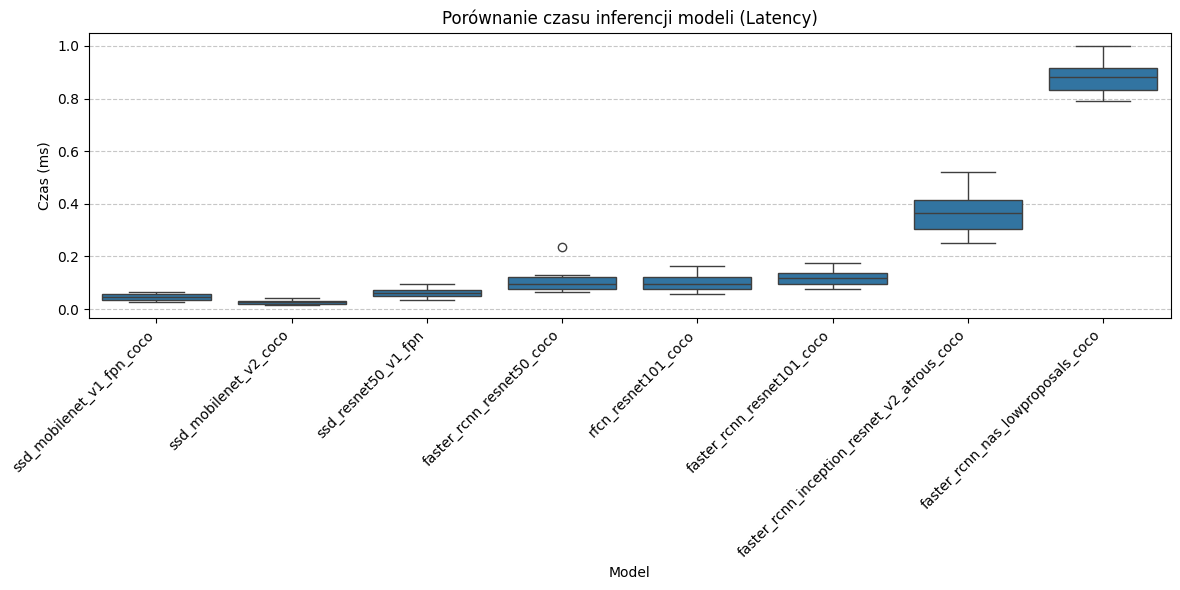

In [ ]:
# Zakładając, że timing_test ma kolumny 'Model' i 'Inference_Time' (lub podobne)
# Jeśli struktura jest inna, dostosuj nazwy kolumn
if not timing_test.empty:
    print("Current columns in timing_test:", timing_test.columns.tolist())

    # Identyfikujemy kolumny, które zawierają czasy inferencji modeli.
    # Są to kolumny o nazwach zawierających 'coco', 'fpn' oraz 'Avg. inference time (ms)'.
    inference_time_cols = [col for col in timing_test.columns if 'inference time' in str(col).lower() or 'coco' in str(col).lower() or 'fpn' in str(col).lower()]

    # Identyfikujemy kolumny opisowe (id_vars) do użycia w funkcji melt.
    descriptive_cols = [col for col in timing_test.columns if col not in inference_time_cols]

    # Przekształcamy DataFrame z formatu szerokiego na długi (melt)
    melted_timing_test = timing_test.melt(
        id_vars=descriptive_cols,
        value_vars=inference_time_cols,
        var_name='Model',
        value_name='Inference_Time_Value'
    )

    # Konwertujemy kolumnę 'Inference_Time_Value' na numeryczną, jeśli jeszcze nie jest
    melted_timing_test['Inference_Time_Value'] = pd.to_numeric(melted_timing_test['Inference_Time_Value'], errors='coerce')

    print("Current columns in melted_timing_test:", melted_timing_test.columns.tolist())
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_timing_test, x='Model', y='Inference_Time_Value')
    plt.title('Porównanie czasu inferencji modeli (Latency)')
    plt.ylabel('Czas (ms)')
    plt.xticks(rotation=45, ha='right') # Rotate and align x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()